# Section Extraction

Documents are often organized into logical sections like chapters, articles, or content blocks. This tutorial shows how to extract these sections using natural-pdf, using a library weeding log as an example.

In [1]:
#%pip install "natural-pdf[all]"

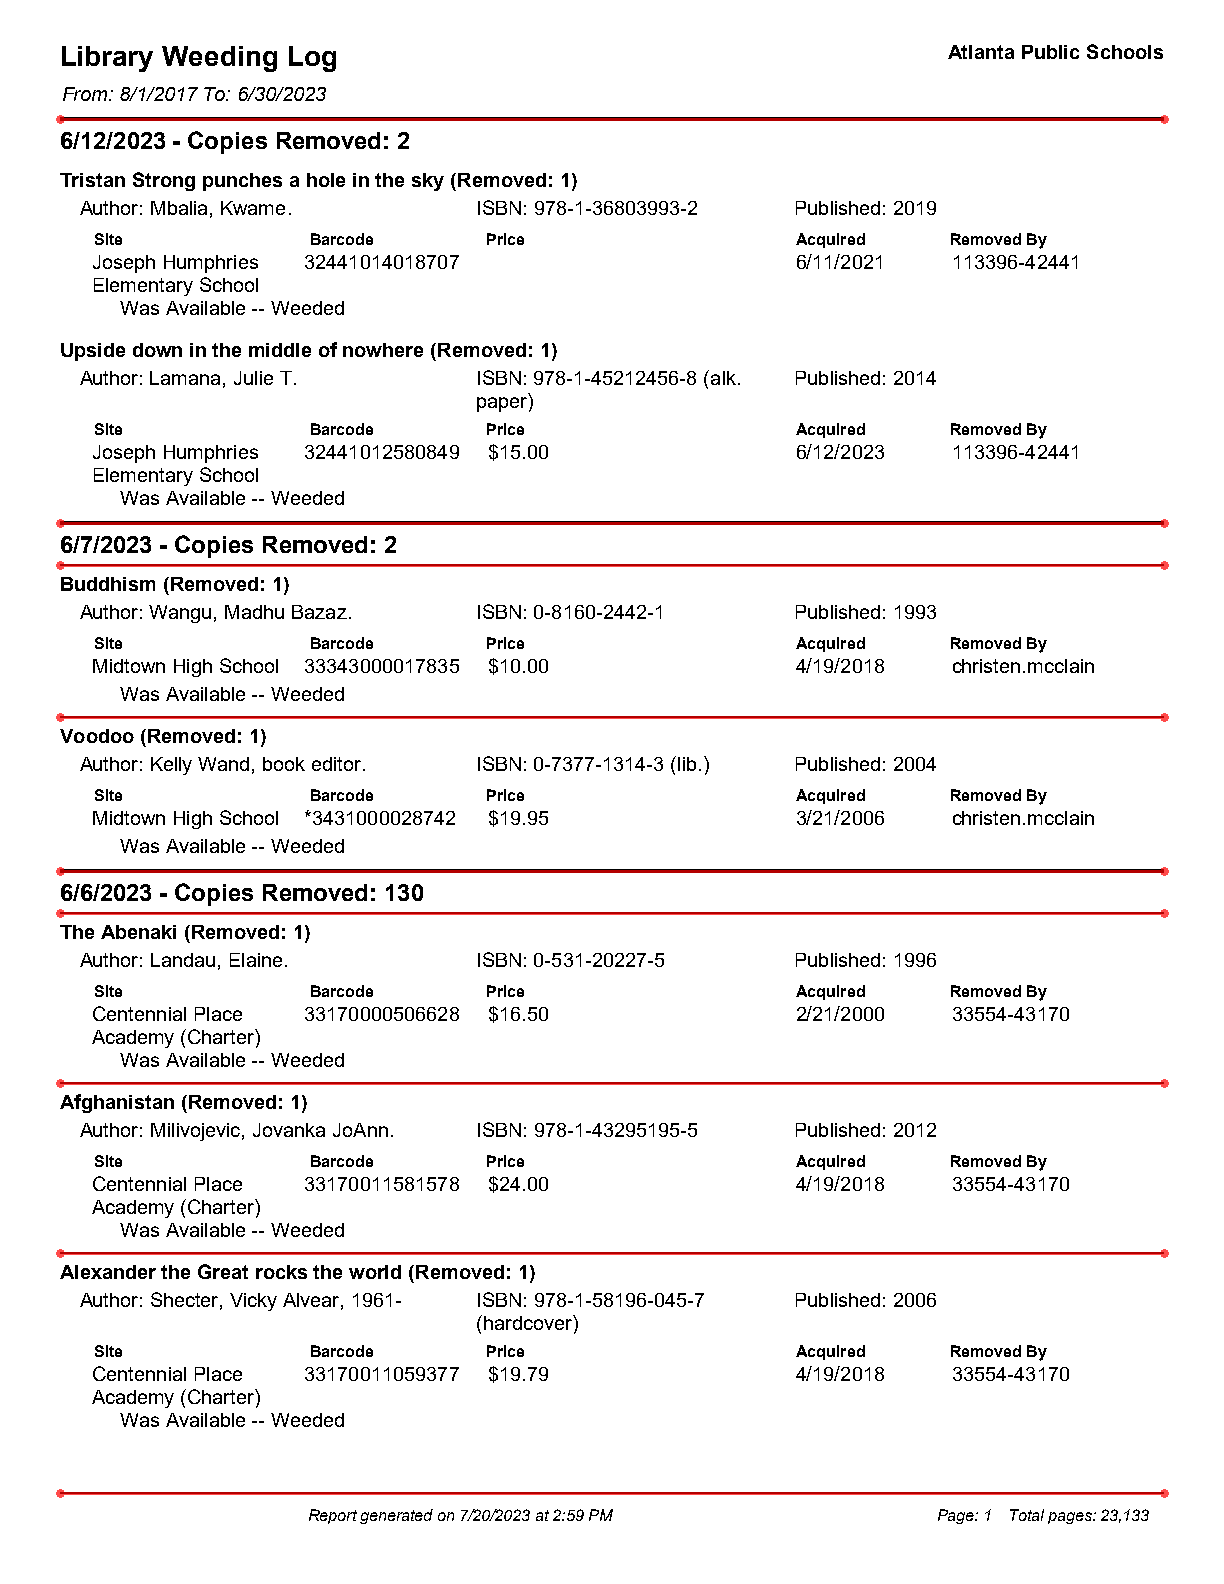

In [2]:
from natural_pdf import PDF

# Load the PDF using the relative path
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/Atlanta_Public_Schools_GA_sample.pdf")
page = pdf.pages[0]

# Find horizontal lines that separate book entries
horizontal_lines = page.find_all('line:horizontal')

# Visualize the potential section boundaries
horizontal_lines.highlight(color="red", label="Section Boundaries")
page.to_image()

In [3]:
# Count what we found
len(horizontal_lines)

9

## Basic Section Extraction

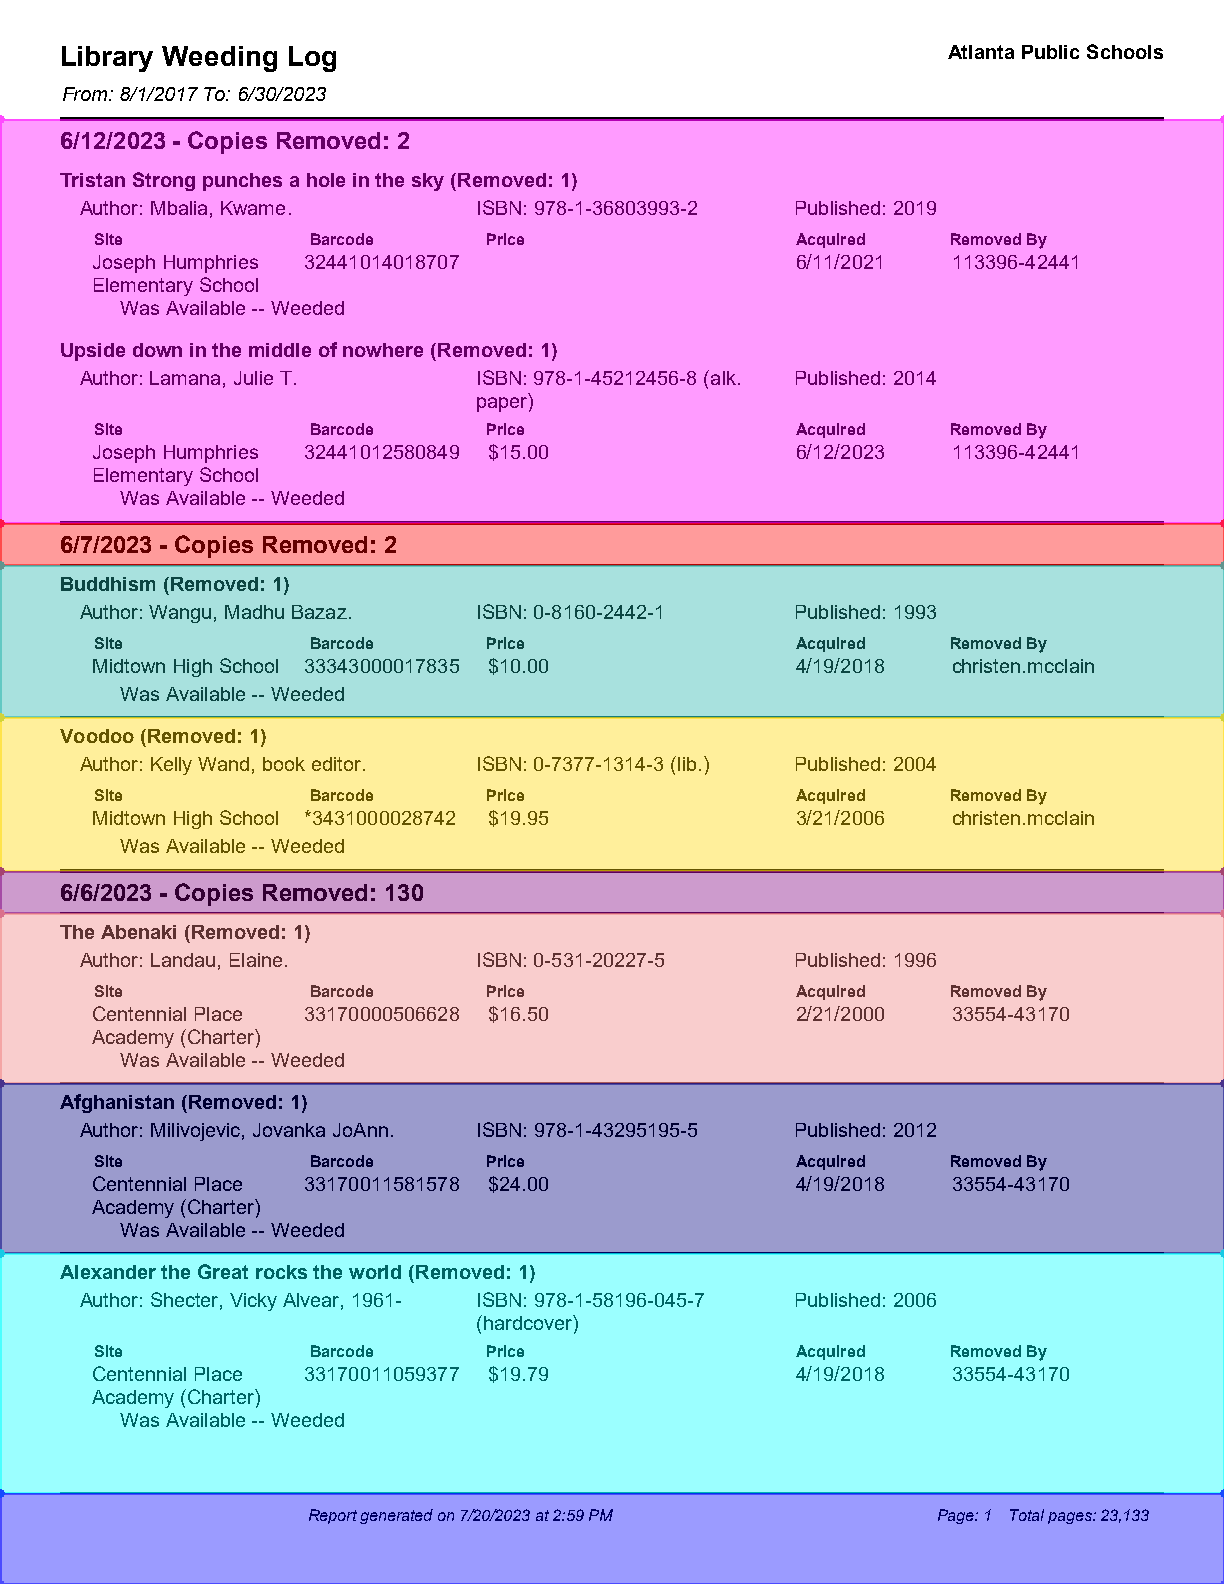

In [4]:
# Extract sections based on horizontal lines
# Each section starts at a horizontal line and ends at the next one
book_sections = page.get_sections(
    start_elements=horizontal_lines,
    boundary_inclusion='start'  # Include the boundary in the section
)

# Visualize each section
page.clear_highlights()
for section in book_sections:
    section.highlight()
page.to_image()

In [5]:
# Display section count and preview the first section
{
    "total_sections": len(book_sections),
    "first_section_text": book_sections[0].extract_text()[:100] + "..." if book_sections else "No sections found"
}

{'total_sections': 9,
 'first_section_text': '6 6/12/2023 - Copies Removed: 2 / 1 2 / 2 0 2 3   -   C o p i e s   R e m o v e d :   2 T Tristan St...'}

## Working with Section Content

In [6]:
# Extract and display content from the first few book entries
book_entries = []

for i, section in enumerate(book_sections[:5]):
    # Extract the section text
    text = section.extract_text().strip()
    
    # Try to parse book information
    title = ""
    author = ""
    isbn = ""
    
    # Extract title (typically the first line)
    title_match = section.find('text:contains("Title:")')
    if title_match:
        title_value = title_match.right(width=400).extract_text()
        title = title_value.strip()
    
    # Extract author
    author_match = section.find('text:contains("Author:")')
    if author_match:
        author_value = author_match.right(width=400).extract_text()
        author = author_value.strip()
    
    # Extract ISBN
    isbn_match = section.find('text:contains("ISBN:")')
    if isbn_match:
        isbn_value = isbn_match.right(width=400).extract_text()
        isbn = isbn_value.strip()
    
    # Add to our collection
    book_entries.append({
        "number": i + 1,
        "title": title,
        "author": author,
        "isbn": isbn,
        "preview": text[:50] + "..." if len(text) > 50 else text
    })

# Display the structured book entries
import pandas as pd
pd.DataFrame(book_entries)

,number,title,author,isbn,preview
0,1,,A Atlanta Public Schools t l a n t a P u b l...,A Atlanta Public Schools t l a n t a P u b l...,6 6/12/2023 - Copies Removed: 2 / 1 2 / 2 0 2 ...
1,2,,,,6 6/7/2023 - Copies Removed: 2 / 7 / 2 0 2 3 ...
2,3,,A Atlanta Public Schools t l a n t a P u b l...,A Atlanta Public Schools t l a n t a P u b l...,B Buddhism (Removed: 1) u d d h i s m ( R e ...
3,4,,A Atlanta Public Schools t l a n t a P u b l...,A Atlanta Public Schools t l a n t a P u b l...,V Voodoo (Removed: 1) o o d o o ( R e m o v ...
4,5,,,,6 6/6/2023 - Copies Removed: 130 / 6 / 2 0 2 3...


## Using Different Section Boundaries


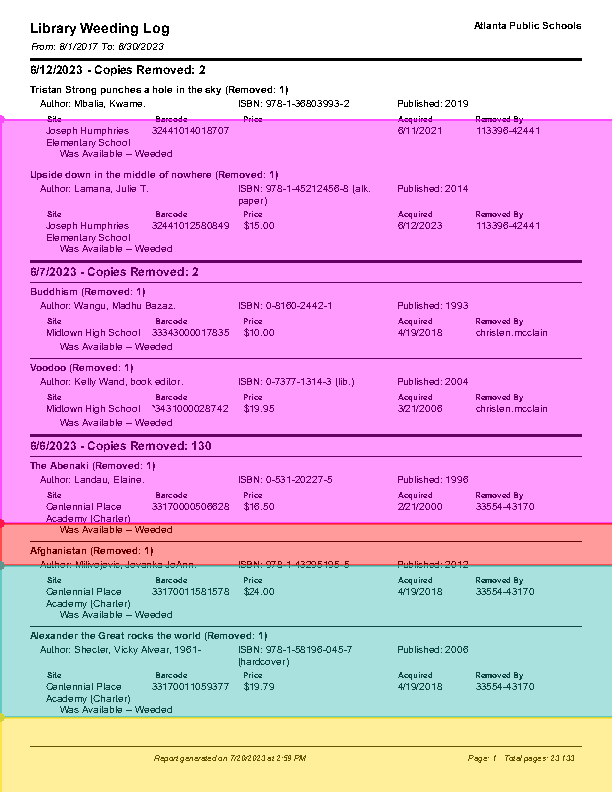

<IPython.core.display.Javascript object>

SimpleInteractiveViewerWidget()

In [7]:
page.viewer()

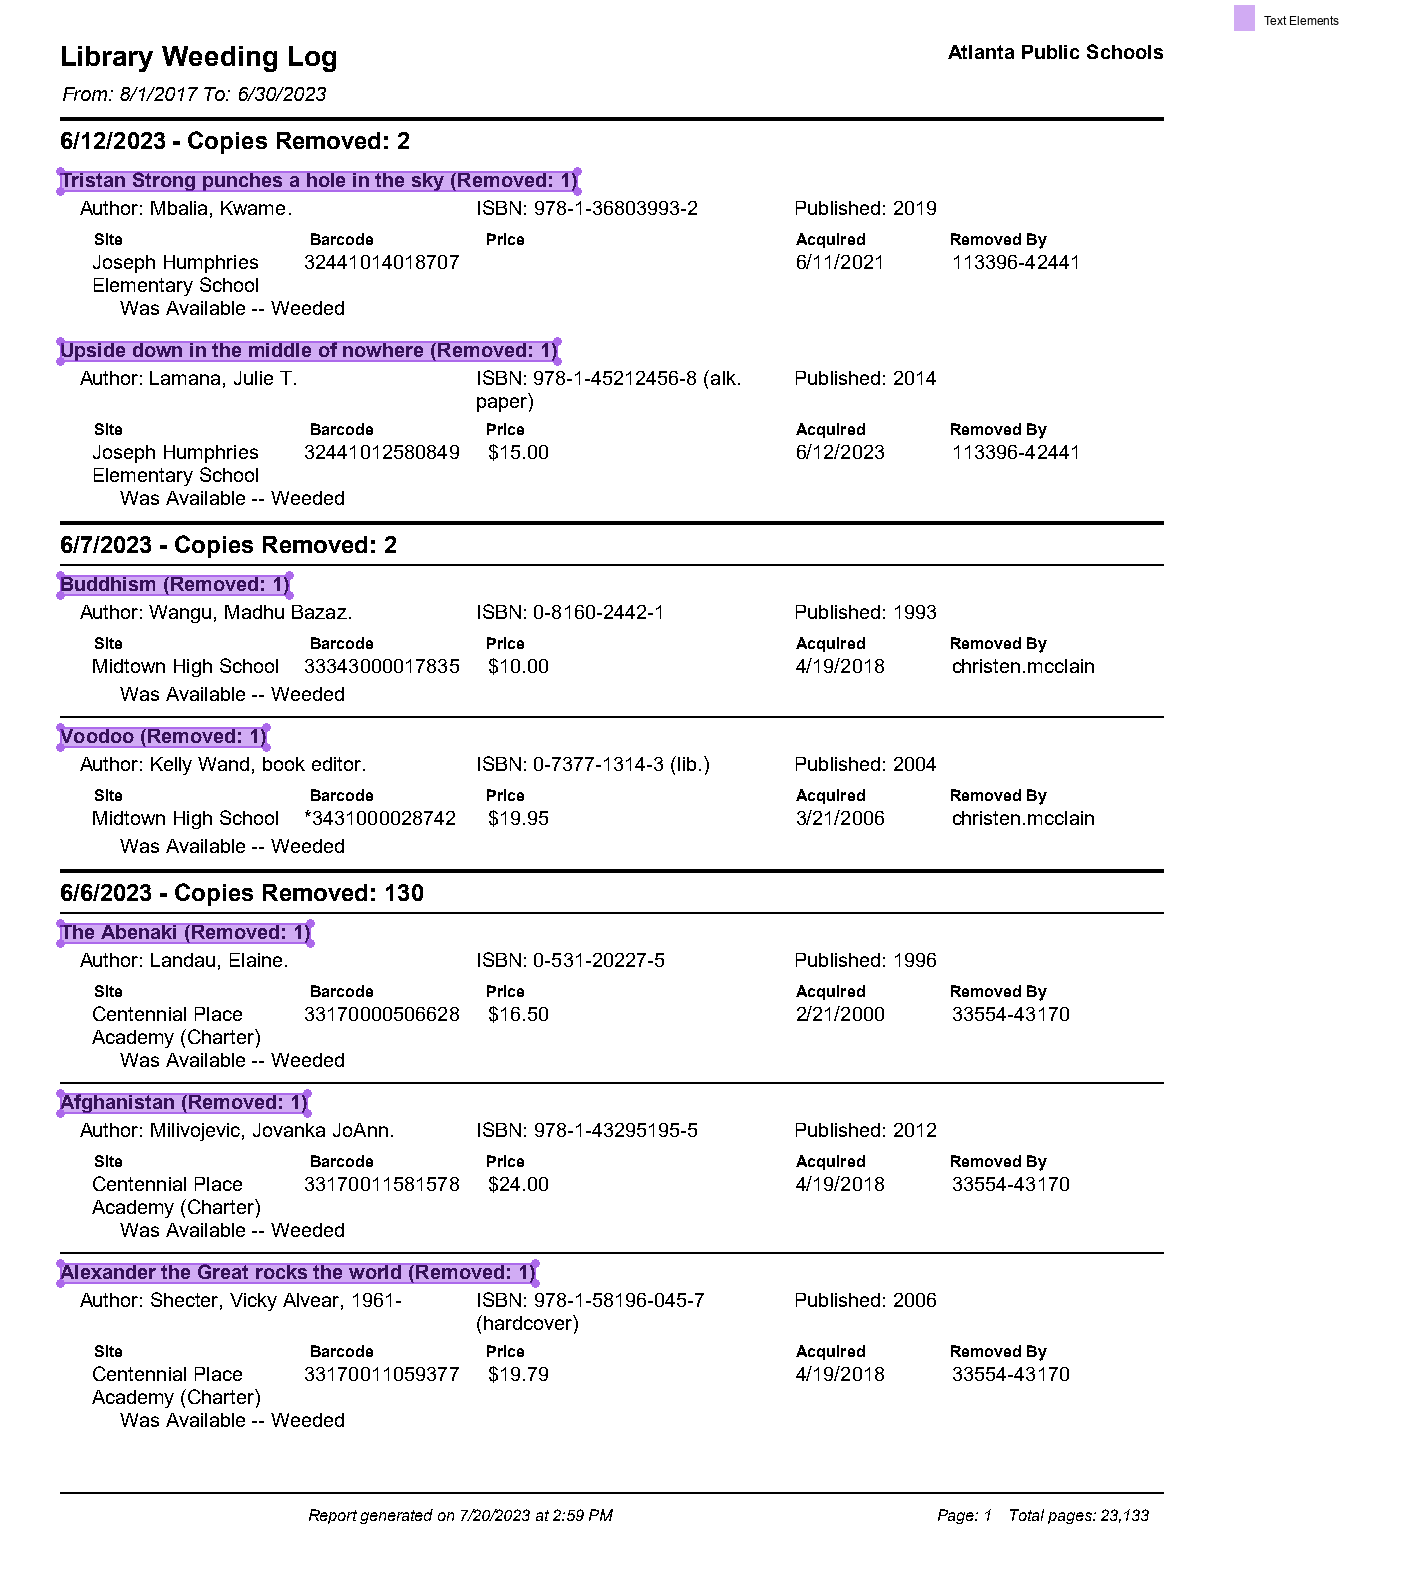

In [8]:
# Find title elements with specific selectors
title_elements = page.find('line[width=2]').below().find_all('text[fontname="AAAAAB+font000000002a8d158a"][size=10]')
title_elements.show()

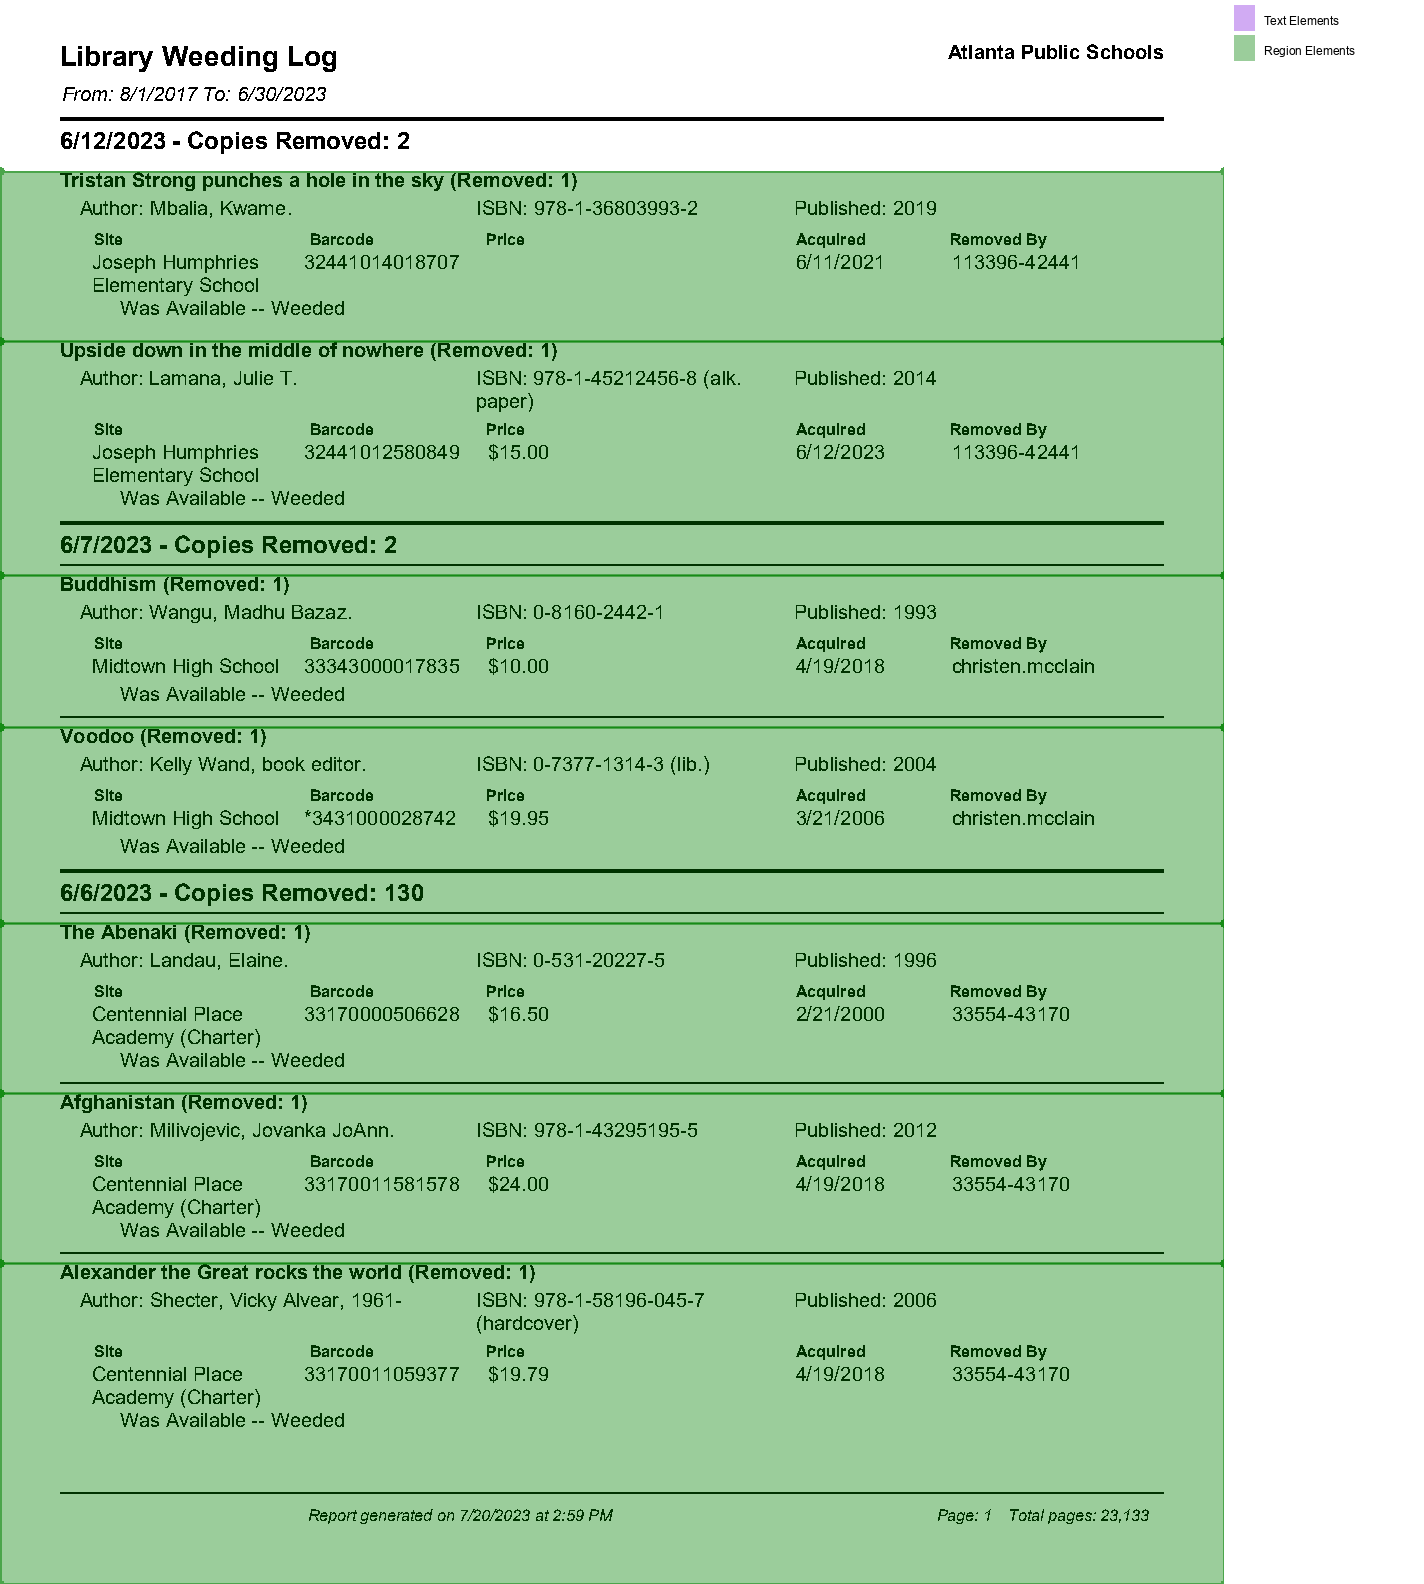

In [9]:
# Extract sections starting from each title
# This now directly returns an ElementCollection
title_sections = page.get_sections(
    start_elements=title_elements,
    boundary_inclusion='start'
)

# Show the title-based sections
page.clear_highlights()
title_sections.highlight()
page.to_image()

In [10]:
# Count the sections found
len(title_sections)

7

## Section Boundary Inclusion Options

In [11]:
# Use horizontal line elements as section dividers
dividers = page.find_all('line[horizontal]')

# Compare the different boundary inclusion options
inclusion_options = {
    'none': page.get_sections(start_elements=dividers, boundary_inclusion='none'),
    'start': page.get_sections(start_elements=dividers, boundary_inclusion='start'),
    'end': page.get_sections(start_elements=dividers, boundary_inclusion='end'),
    'both': page.get_sections(start_elements=dividers, boundary_inclusion='both')
}

# Count sections with each option
section_counts = {option: len(sections) for option, sections in inclusion_options.items()}
section_counts

{'none': 9, 'start': 9, 'end': 9, 'both': 9}

## Custom Section Boundaries

T Tristan Strong punches a hole in the sky (Removed: 1) r i s t a n   S t r o n g   p u n c h e s   a   h o l e   i n   t h e   s k y   ( R e m o v e d :   1 ) A Author: Mbalia, Kwame. u t h o r :   M b a l i a ,   K w a m e . I ISBN: 978-1-36803993-2 S B N :   9 7 8 - 1 - 3 6 8 0 3 9 9 3 - 2 P Published: 2019 u b l i s h e d :   2 0 1 9 S Site i t e B Barcode a r c o d e P Price r i c e A Acquired c q u i r e d R Removed By e m o v e d   B y J Joseph Humphries o s e p h   H u m p h r i e s 3 32441014018707 2 4 4 1 0 1 4 0 1 8 7 0 7 6 6/11/2021 / 1 1 / 2 0 2 1 1 113396-42441 1 3 3 9 6 - 4 2 4 4 1 E Elementary School l e m e n t a r y   S c h o o l W Was Available -- Weeded a s   A v a i l a b l e   - -   W e e d e d


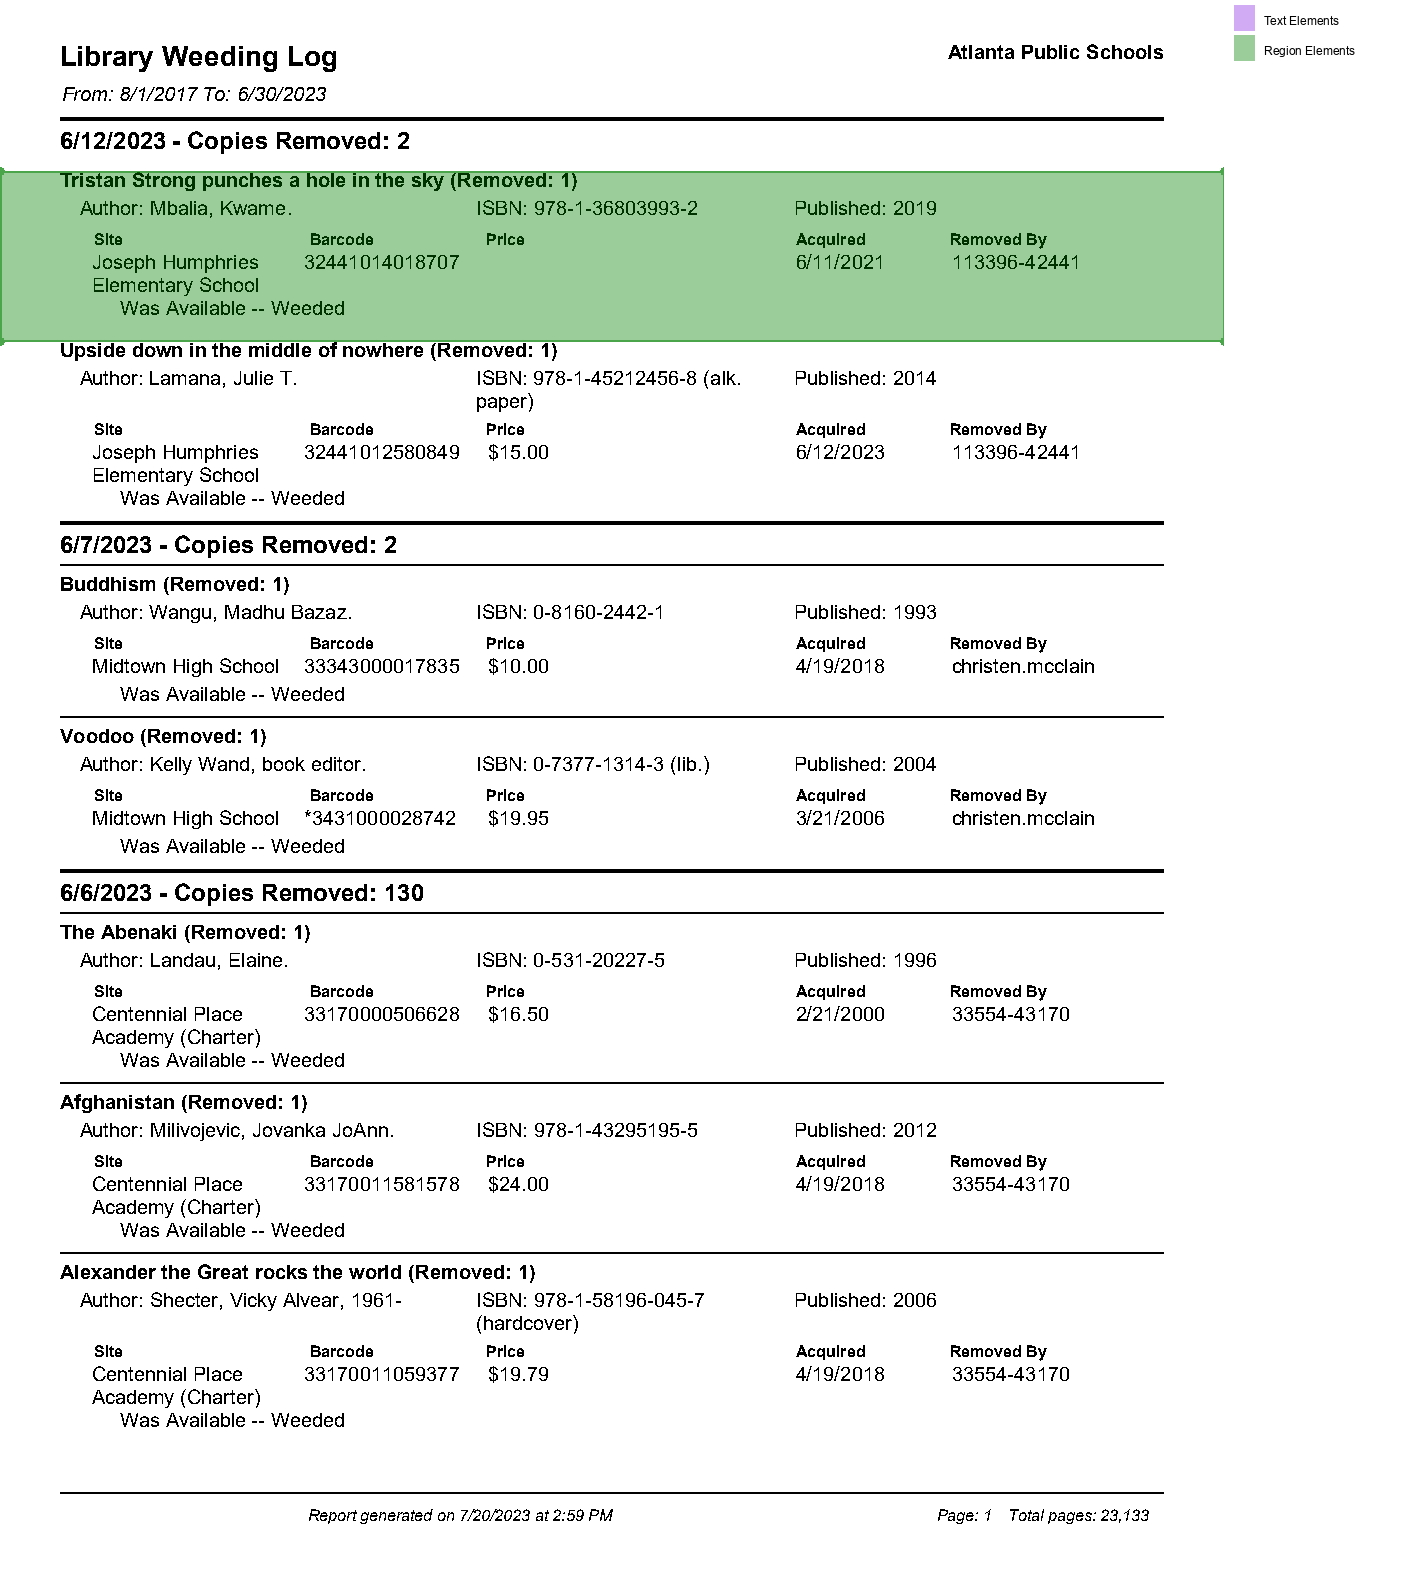

In [12]:
# Define specific start and end points - let's extract just one book entry
# We'll look for the first and second horizontal lines
page.clear_highlights()

start_point = title_elements[0]
end_point = title_elements[1]

# Extract the section between these points
single_book_entry = page.get_sections(
    start_elements=[start_point],
    end_elements=[end_point],
    boundary_inclusion='start'  # Include the start but not the end
)
    
# Visualize the custom section
single_book_entry.highlight(color="green", label="Single Book Entry")
    
print(single_book_entry[0].extract_text())

page.to_image()

## Multi-page Sections

In [13]:
# Get sections across the first two pages
multi_page_sections = [] # Initialize as a list

for page_num in range(min(2, len(pdf.pages))):
    page = pdf.pages[page_num]
    
    # Find horizontal lines on this page
    title_elements = page.find('line[width=2]').below().find_all('text[fontname="AAAAAB+font000000002a8d158a"][size=10]')
    
    # Get sections for this page (returns ElementCollection)
    page_sections = page.get_sections(
        start_elements=title_elements,
        boundary_inclusion='start'
    )
    
    # Add elements from the collection to our list
    multi_page_sections.extend(page_sections) # list.extend works with iterables like ElementCollection

# Display info about each section (showing first 3)
[{
    "page": section.page.number + 1,  # 1-indexed page number for display
    "text": section.extract_text()[:50] + "..." if len(section.extract_text()) > 50 else section.extract_text()
} for section in multi_page_sections]

[{'page': 2, 'text': 'T Tristan Strong punches a hole in the sky (Remove...'},
 {'page': 2, 'text': 'U Upside down in the middle of nowhere (Removed: 1...'},
 {'page': 2, 'text': 'B Buddhism (Removed: 1) u d d h i s m   ( R e m o ...'},
 {'page': 2, 'text': 'V Voodoo (Removed: 1) o o d o o   ( R e m o v e d ...'},
 {'page': 2, 'text': 'T The Abenaki (Removed: 1) h e   A b e n a k i   (...'},
 {'page': 2, 'text': 'A Afghanistan (Removed: 1) f g h a n i s t a n   (...'},
 {'page': 2, 'text': 'A Alexander the Great rocks the world (Removed: 1)...'},
 {'page': 3, 'text': 'T The Anasazi (Removed: 1) h e   A n a s a z i   (...'},
 {'page': 3, 'text': 'A And then what happened, Paul Revere? (Removed: 1...'},
 {'page': 3, 'text': 'T The assassination of Martin Luther King Jr (Remo...'},
 {'page': 3, 'text': 'B Barbara Jordan. (Removed: 1) a r b a r a   J o r...'},
 {'page': 3, 'text': 'B Bedtime for Batman (Removed: 1) e d t i m e   f ...'},
 {'page': 3, 'text': 'B Benjamin O. Davis, Jr : Air 

## Building a Book Database

In [14]:
# Extract all book entries across multiple pages
book_database = []

# Process first 3 pages (or fewer if the document is shorter)
for page_num in range(min(3, len(pdf.pages))):
    page = pdf.pages[page_num]
    
    # Find horizontal lines on this page
    title_elements = page.find('line[width=2]').below().find_all('text[fontname="AAAAAB+font000000002a8d158a"][size=10]')
    
    # Get sections for this page
    book_sections = page.get_sections(
        start_elements=title_elements,
        boundary_inclusion='start'
    )
    
    # Process each book section
    for section in book_sections:
        # Skip sections that are too short (might be headers/footers)
        if len(section.extract_text()) < 50:
            continue
            
        # Extract book information
        book_info = {"page": page_num + 1}
        
        for field in ["Title:", "Author:", "ISBN:", "Publisher:", "Copyright:"]:
            field_element = section.find(f'text:contains("{field}")')
            if field_element:
                field_name = field.strip(':').lower()
                field_value = field_element.extract_text().replace(field, '').strip()
                book_info[field_name] = field_value

        # Below the field name
        for field in ["Price", "Acquired", "Barcode", "Removed By"]:
            field_element = section.find(f'text:contains("{field}")')
            if field_element:
                field_name = field.lower()
                field_value = field_element.below(height=10, width='element').expand(right=50).extract_text().strip()
                book_info[field_name] = field_value

        book_database.append(book_info)

# Display sample entries (first 3)
import pandas as pd

df = pd.json_normalize(book_database)
df.head()

,page,author,isbn,price,acquired,barcode,removed by
0,1,"Mbalia, Kwame.",978-1-36803993-2,,6 6/11/2021 / 1 1 / 2 0 2 1 1,32441014018707 2 4 4 1 0 1 4 0 1 8 7 0 7,1 113396-42441 1 3 3 9 6 - 4 2 4 4 1
1,1,"Lamana, Julie T.",978-1-45212456-8 (alk.,$ $15.00 1 5 . 0 0,6 6/12/2023 / 1 2 / 2 0 2 3 1,32441012580849 2 4 4 1 0 1 2 5 8 0 8 4 9,1 113396-42441 1 3 3 9 6 - 4 2 4 4 1
2,1,"Wangu, Madhu Bazaz.",0-8160-2442-1,$ $10.00 1 0 . 0 0,4 4/19/2018 / 1 9 / 2 0 1 8 c,33343000017835 3 3 4 3 0 0 0 0 1 7 8 3 5,c christen.mcclain h r i s t e n . m c c l a i n
3,1,"Kelly Wand, book editor.",0-7377-1314-3 (lib.),$ $19.95 1 9 . 9 5,3 3/21/2006 / 2 1 / 2 0 0 6 c,*3431000028742 3 4 3 1 0 0 0 0 2 8 7 4 2,c christen.mcclain h r i s t e n . m c c l a i n
4,1,"Landau, Elaine.",0-531-20227-5,$ $16.50 1 6 . 5 0,2 2/21/2000 / 2 1 / 2 0 0 0 3,33170000506628 3 1 7 0 0 0 0 5 0 6 6 2 8,3 33554-43170 3 5 5 4 - 4 3 1 7 0


Section extraction lets you break down documents into logical parts, making it easier to generate summaries, extract specific content, and create structured data from semi-structured documents. In this example, we've shown how to convert a PDF library catalog into a structured book database. 